# SuperGradients Walkthrough Notebook 





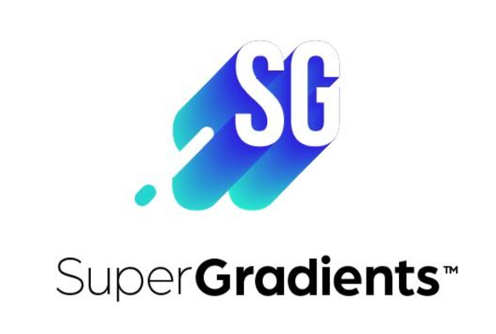

*Hi there and welcome to SuperGradients, a free open-source training library for PyTorch-based deep learning models.   Let's have a quick look at the SuperGradients library features. The library lets you train models from any Computer Vision tasks or import pre-trained SOTA models, such as object detection, classification of images, and semantic segmentation for videos or images use cases.*

*Whether you are a beginner or an expert it is likely that you already have your own training script, model, loss function implementation etc.
In this notebook we present the modifications needed in order to launch your training so you can benefit from the various tools the SuperGradients has to offer.*


## "Wait, but what's in it for me?"

Great question! our short answer is - Easy to use SOTA DL training library.

Our long answer - 

*   Train models from any Computer Vision tasks or import [pre-trained SOTA models](https://github.com/Deci-AI/super-gradients#pretrained-classification-pytorch-checkpoints) (detection, segmentation, and classification - YOLOv5, DDRNet, EfficientNet, RegNet, ResNet, MobileNet, etc.)
*  Shorten the training process using tested and proven [recipes](https://github.com/Deci-AI/super-gradients/tree/master/recipes) & [code examples](https://github.com/Deci-AI/super-gradients/tree/master/examples)
*  Easily configure your own or  use plug&play training, dataset , and architecture parameters.
*  Save time and easily integrate it into your codebase.







## Walkthrough Steps:

1.  Installations
2.  Integrating your dataset
3.  Integrating your neural network architecture
5.  Integrating your loss function
6.  Putting it all together
7.  Defining our metrics of evaluation
8.  Defining training parameters
9.  Training execution


> **NOTE:** The defult hardware is CPU, if you want to use Google Collab's GPU you need to follow these steps- 

- Press "Runtime" in manu bar
- Choose "Change runtime type"
- Hardware accelerator - choose "GPU"
- Press "Save"
- Restart Runtime

## Installations

In [ ]:
# SuperGradients installation
# !pip install super-gradients
! pip install https://deci-build-essentials-development.s3.amazonaws.com/super_gradients-0.1.0rc666-py3-none-any.whl gwpy &> /dev/null
# To install from source instead of the last release, comment the command above and uncomment the following one.
# !pip install git+https://github.com/Deci-AI/super_gradients.git

## **Getting Started With Training a Model**

> **NOTE:** All code examples presented in the documentation are in PyTorch framework.

### Integrating Your Dataset

In order to integrate your own dataset with our training scheme, we introduce the *dataset_interface* concept, which wraps the *torch dataloaders* used for training.
The specified dataset interface class must inherit from deci_trainer.trainer.datasets.dataset_interfaces.dataset_interface, which is where data augmentation and data loader configurations are defined.
For instance, a dataset interface for Cifar10:


In [ ]:
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from super_gradients.training import utils as core_utils
from super_gradients.training.datasets.dataset_interfaces import DatasetInterface


class UserDataset(DatasetInterface):

    def __init__(self, name="cifar10", dataset_params={}):
        super(UserDataset, self).__init__(dataset_params)
        self.dataset_name = name
        self.lib_dataset_params = {'mean': (0.4914, 0.4822, 0.4465), 'std': (0.2023, 0.1994, 0.2010)}

        crop_size = core_utils.get_param(self.dataset_params, 'crop_size', default_val=32)

        transform_train = transforms.Compose([
            transforms.RandomCrop(crop_size, padding=4),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(self.lib_dataset_params['mean'], self.lib_dataset_params['std']),
        ])

        transform_test = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(self.lib_dataset_params['mean'], self.lib_dataset_params['std']),
        ])

        self.trainset = datasets.CIFAR10(root=self.dataset_params.dataset_dir, train=True, download=True,
                                         transform=transform_train)

        self.valset = datasets.CIFAR10(root=self.dataset_params.dataset_dir, train=False, download=True,
                                        transform=transform_test)


Required parameters can be passed using the python dataset_params argument. When implementing a dataset interface, the *trainset* and *valset* attributes are required and must be initiated with a torch.utils.data.Dataset type.
 These fields will cause the SGModel instance to use them accordingly, such as during training, validation, and so on.

### Integrating Your Neural Network Architecture

This is rather straightforward- the only requirement is that the model must be of torch.nn.Module type. In our case, a simple Lenet implementation (taken from https://github.com/icpm/pytorch-cifar10/blob/master/models/LeNet.py).

In [ ]:
import torch.nn as nn
import torch.nn.functional as func


class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = func.relu(self.conv1(x))
        x = func.max_pool2d(x, 2)
        x = func.relu(self.conv2(x))
        x = func.max_pool2d(x, 2)
        x = x.view(x.size(0), -1)
        x = func.relu(self.fc1(x))
        x = func.relu(self.fc2(x))
        x = self.fc3(x)
        return x

### Integrating Your Loss Function

The loss function class must be of torch.nn.module._LOSS type. For example, our LabelSmoothingCrossEntropyLoss implementation

In [ ]:
import torch.nn as nn
from super_gradients.training.losses.label_smoothing_cross_entropy_loss import cross_entropy

class LabelSmoothingCrossEntropyLoss(nn.CrossEntropyLoss):
    def __init__(self, weight=None, ignore_index=-100, reduction='mean', smooth_eps=None, smooth_dist=None,
                 from_logits=True):
        super(LabelSmoothingCrossEntropyLoss, self).__init__(weight=weight,
                                                             ignore_index=ignore_index, reduction=reduction)
        self.smooth_eps = smooth_eps
        self.smooth_dist = smooth_dist
        self.from_logits = from_logits

    def forward(self, input, target, smooth_dist=None):
        if smooth_dist is None:
            smooth_dist = self.smooth_dist
        loss = cross_entropy(input, target, weight=self.weight, ignore_index=self.ignore_index,
                             reduction=self.reduction, smooth_eps=self.smooth_eps,
                             smooth_dist=smooth_dist, from_logits=self.from_logits)

        return loss

You did not mention an AWS environment.You can set the environment variable ENVIRONMENT_NAME with one of the values: development,staging,production
callbacks -WARNING- Failed to import deci_lab_client


### Putting It All Together

We instantiate an SgModel and a UserDatasetInterface, then call *connect_dataset_interface* which will initialize the dataloaders and pass additional dataset parameters to the SgModel instance.

In [ ]:
from super_gradients.training import SgModel

sg_model = SgModel(experiment_name='LeNet_cifar10_example')
dataset_params = {"batch_size": 256}
dataset = UserDataset(dataset_params)
sg_model.connect_dataset_interface(dataset)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data/
Files already downloaded and verified


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Now, we pass a LeNet instance we defined above to the SgModel:

In [ ]:
network = LeNet()
sg_model.build_model(network)

Next, we define metrics in order to valuate our model.
The metrics objects to be logged during training must be of torchmetrics.Metric type. For more information on how to use torchmetric.Metric objects and implement your own metrics. see https://torchmetrics.readthedocs.io/en/latest/pages/overview.html.
During training, the metric's update is called with the model's raw outputs and raw targets. Therefore, any processing of the two must be taken into account and applied in the update.

For most of the familiar cases, an existing torchmetric.Metric implementation exists in super_gradients.training.metrics. Here we simply use the SuperGradients Top1 and Top5 accuracy metrics in order to define the metrics for evaluation on the train set and the validation set.

In [ ]:
from super_gradients.training.metrics import Accuracy, Top5

train_metrics_list = [Accuracy(), Top5()]
valid_metrics_list = [Accuracy(), Top5()]

### Defining Your Training Parameters
Finally, we can define the training parameters:

In [ ]:
train_params = {"max_epochs": 10,
                "lr_updates": [100, 150, 200],
                "lr_decay_factor": 0.1,
                "lr_mode": "step",
                "lr_warmup_epochs": 0,
                "initial_lr": 0.1,
                "loss": LabelSmoothingCrossEntropyLoss(),
                "criterion_params": {},
                "optimizer": "SGD",
                "optimizer_params": {"weight_decay": 1e-4, "momentum": 0.9},
                "launch_tensorboard": False,
                "train_metrics_list": train_metrics_list,
                "valid_metrics_list": valid_metrics_list,
                "loss_logging_items_names": ["Loss"],
                "metric_to_watch": "Accuracy",
                "greater_metric_to_watch_is_better": True}
                

sg_model -INFO- Started training for 10 epochs (0/9)



Train epoch 0:   0%|          | 0/782 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/cuda/memory.py:386: FutureWarning: torch.cuda.memory_cached has been renamed to torch.cuda.memory_reserved
  FutureWarning)
Validation epoch 0: 100%|██████████| 50/50 [00:03<00:00, 14.33it/s]

sg_model -INFO- Best checkpoint overriden: validation Accuracy: 0.1454000025987625



Validation epoch 1: 100%|██████████| 50/50 [00:03<00:00, 14.52it/s]

sg_model -INFO- Best checkpoint overriden: validation Accuracy: 0.23319999873638153



Validation epoch 9: 100%|██████████| 50/50 [00:03<00:00, 14.37it/s]

sg_model -INFO- RUNNING ADDITIONAL TEST ON THE AVERAGED MODEL...



Validation epoch 10: 100%|██████████| 50/50 [00:03<00:00, 14.32it/s]


### Training Execution
Now that all of the parameters and integrations are done we can simply call *train*:

In [ ]:
sg_model.train(train_params)

> **Training Parameter Notes:**
\
loss_logging_items_names parameter – Refers to the single item returned by our loss function described above.
*metric_to_watch* – Is the model’s metric that determines the checkpoint to be saved. In our example, this parameter is set to Accuracy, and can be set to any of the following:
A metric name (str) of one of the metric objects from the *valid_metrics_list* or "Loss" (which refers to the validation loss).
*greater_metric_to_watch_is_better* flag – Determines when to save a model's checkpoint according to the value of the metric_to_watch.

## Conclusion

Great job! You have finished a full walkthrough of SuperGradients components for deep learning models' training. You can now try out our [pre-trained models fine tune notebook](https://colab.research.google.com/drive/1FsMo11hFw6OS1e1x1-LFda23vrihspdz#scrollTo=0kufTIGMff9y), or train your own models using our SOTA models' [recipes](https://github.com/Deci-AI/super-gradients/tree/master/recipes).